## Use pre-trained autoencoder to learn the predictor

In [3]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

In [4]:
_d = np.load('../data/data_clean_128_train.npz')
X = _d['X']
Y = _d['Y']

# Turn labels into boolean present/missing
Y_binary = np.sum(np.sum(Y, axis=2), axis=1) > 0
Y_binary = Y_binary.astype(np.float32)

In [5]:
# Also load the non-filtered data for evaluation
_d = np.load('../data/data_128_train.npz')
X_full = _d['X'][:,None,:,:]
Y_full = _d['Y'][:,None,:,:]

In [6]:
_d = np.load('../data/data_128_test.npz')
X_submit = _d['X'][:,None,:,:]

In [7]:
print X.shape
print Y.shape
print X_submit.shape

(3906, 128, 128)
(3906, 128, 128)
(5508, 1, 128, 128)


In [8]:
nsamples = X.shape[0]

train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.1)
#train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.25)
X_train = X[train_indices][:,None,:,:]
Y_train_binary = Y_binary[train_indices][:,None]
Y_train = Y[train_indices][:,None,:,:]
X_test = X[test_indices][:,None,:,:]
Y_test_binary = Y_binary[test_indices][:,None]
Y_test = Y[test_indices][:,None,:,:]

In [9]:
X_train2 = np.concatenate((X_train, X_submit), axis=0)
print X_train2.shape

(9023, 1, 128, 128)


In [10]:
print X_train.shape
print Y_train.shape
print Y_train_binary.shape
print X_train.min(), X_train.max()

(3515, 1, 128, 128)
(3515, 1, 128, 128)
(3515, 1)
0.0 1.0


/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


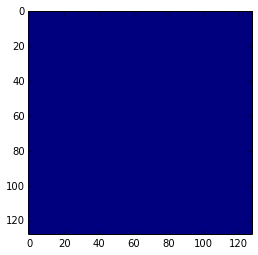

In [11]:
#pl.imshow(X_train[0].squeeze())
pl.imshow(Y_train[0].squeeze())

# Keras model

In [24]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float16'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import LeakyReLU, ZeroPadding2D
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import keras.backend as K

In [25]:
import theano
print theano.config.device

gpu0


In [91]:
def load_autoencoder():
    model_dir = '../models/autoencoder_128'
    model = model_from_json(open(os.path.join(model_dir, 'architecture.json')).read())
    model.load_weights(os.path.join(model_dir, 'weights.hdf5'))
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

autoencoder = load_autoencoder()
#print_summary(autoencoder.layers)

# This is to sanity check that weights are not reinitialized
conv5_weights = autoencoder.layers[26].get_weights()[0]

In [92]:
layer_dict = dict([(layer.name, layer) for layer in autoencoder.layers])
input_img = layer_dict['input_16'].input
pool1 = layer_dict['pool1'].output
pool2 = layer_dict['pool2'].output
pool3 = layer_dict['pool3'].output
pool4 = layer_dict['pool4'].output
pool5 = layer_dict['pool5'].output

conv5 = layer_dict['convolution2d_249']

for layer in autoencoder.layers:
    layer.trainable = False

# Since some images have not mask, the hope is that the innermost units capture this
x = Flatten()(pool5)
x = Dense(32)(x)
x = LeakyReLU()(x)
x = Dense(16)(x)
x = LeakyReLU()(x)
outbin = Dense(1, activation='sigmoid', name='outbin')(x)

# -- location map
x = Convolution2D(16, 3, 3, border_mode='same')(pool3)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool2], mode='concat', concat_axis=1)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool1], mode='concat', concat_axis=1)
x = Convolution2D(16, 5, 5, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

outmap = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same', name='outmap')(x)

model = Model(
    input=input_img,
    output=[outmap, outbin]
)

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='binary_crossentropy')
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
#model.compile(optimizer=rmsprop, loss='binary_crossentropy')
model.compile(optimizer='adam', loss='binary_crossentropy',
              loss_weights=[1., 0.01])

# check that autoencoder weights are not reinitialized
assert np.allclose(conv5.get_weights()[0], conv5_weights)

print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_16 (InputLayer)              (None, 1, 128, 128) 0                                            
____________________________________________________________________________________________________
convolution2d_240 (Convolution2D)  (None, 16, 128, 128)160         input_16[0][0]                   
____________________________________________________________________________________________________
leakyrelu_237 (LeakyReLU)          (None, 16, 128, 128)0           convolution2d_240[0][0]          
____________________________________________________________________________________________________
convolution2d_241 (Convolution2D)  (None, 16, 128, 128)2320        leakyrelu_237[0][0]              
___________________________________________________________________________________________

In [93]:
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

#from keras.utils.visualize_util import plot
#plot(model, to_file='model.png')

Train on 3515 samples, validate on 391 samples
Epoch 1/40
3515/3515 [==============================] - 23s - loss: 0.3015 - outmap_loss: 0.2950 - outbin_loss: 0.6485 - val_loss: 0.0812 - val_outmap_loss: 0.0749 - val_outbin_loss: 0.6316
Epoch 2/40
3515/3515 [==============================] - 23s - loss: 0.0589 - outmap_loss: 0.0529 - outbin_loss: 0.5966 - val_loss: 0.0495 - val_outmap_loss: 0.0435 - val_outbin_loss: 0.5989
Epoch 3/40
3515/3515 [==============================] - 23s - loss: 0.0460 - outmap_loss: 0.0404 - outbin_loss: 0.5655 - val_loss: 0.0443 - val_outmap_loss: 0.0387 - val_outbin_loss: 0.5633
Epoch 4/40
3515/3515 [==============================] - 23s - loss: 0.0421 - outmap_loss: 0.0367 - outbin_loss: 0.5348 - val_loss: 0.0432 - val_outmap_loss: 0.0378 - val_outbin_loss: 0.5425
Epoch 5/40
3515/3515 [==============================] - 23s - loss: 0.0400 - outmap_loss: 0.0349 - outbin_loss: 0.5132 - val_loss: 0.0426 - val_outmap_loss: 0.0372 - val_outbin_loss: 0.5438
Epo

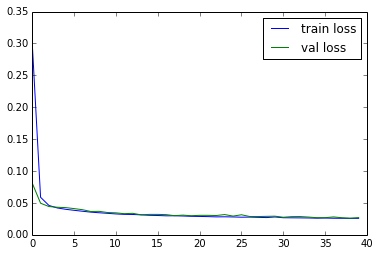

In [94]:
if True:
    json_string = model.to_json()
    open('architecture.json', 'w').write(json_string)
    
    model_checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True, verbose=True)
    
    history = model.fit(
        X_train,
        {'outmap': Y_train, 'outbin': Y_train_binary},
        batch_size=128,
        validation_data=(X_test, {'outmap': Y_test, 'outbin': Y_test_binary}),
        nb_epoch=40,# 40 + 10 + 10 + 5 + 5
        verbose=1,
        shuffle=True,
        callbacks=[model_checkpoint]
    )
    pl.plot(history.history['loss'], label='train loss')
    pl.plot(history.history['val_loss'], c='g', label='val loss')
    pl.legend()
else:
    model_dir = '.'
    model = model_from_json(open(os.path.join(model_dir, 'architecture.json')).read())
    model.load_weights(os.path.join(model_dir, 'weights.h5'))
    model.compile(optimizer='adagrad', loss='mse')
    
    print_summary(model.layers)

In [95]:
if False:
    model_dir = '.'
    json_string = model.to_json()
    open(os.path.join(model_dir, 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join(model_dir, 'weights.hdf5'))

In [98]:
def predict(X):
    Y_pred, Y_pred_binary = model.predict(X)
    Y_pred_binary = Y_pred_binary.squeeze()
    Y_pred_proba = Y_pred
    Y_pred = Y_pred > 0.3
    for i in range(Y_pred.shape[0]):
        # Clear prediction where we detect to little pixels
        # Figure it out by
        # pl.hist(np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1))
        if np.sum(Y_pred[i]) < 50 or Y_pred_binary[i] < 0.3:
            Y_pred[i,:] = 0
    return Y_pred, Y_pred_proba

Y_pred, Y_pred_proba = predict(X_test)
Y_full_pred, Y_full_pred_proba = predict(X_full)

print "test set score : ", utils.dice_coefficient(Y_pred, Y_test)
print "full set score : ", utils.dice_coefficient(Y_full_pred, Y_full)

test set score :  0.650702361216
full set score :  0.565179451856


In [99]:
# Find the images with lowest scores
dice_scores = []
for i in range(Y_full_pred.shape[0]):
    dice_scores.append(utils.dice_coefficient(Y_full_pred[i], Y_full[i]))
dice_scores = np.array(dice_scores)
lowest = np.argsort(dice_scores)

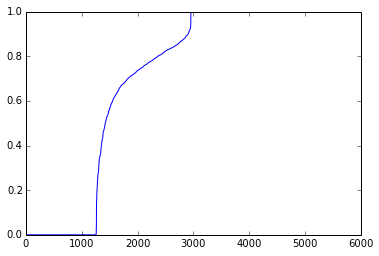

In [100]:
pl.plot(dice_scores[lowest])
#pl.plot(Y_pred_binary[lowest], c='r')

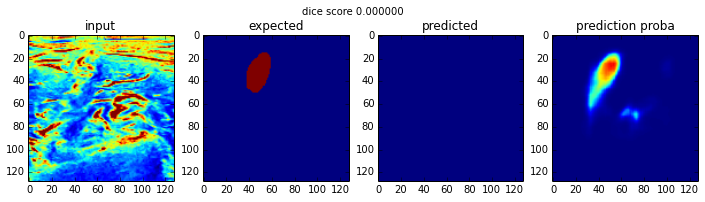

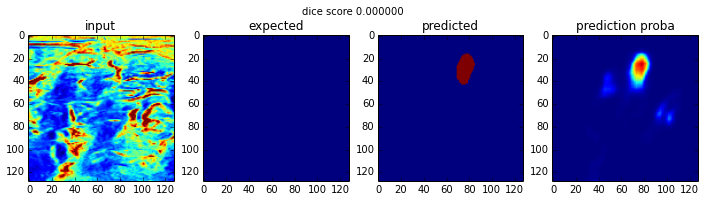

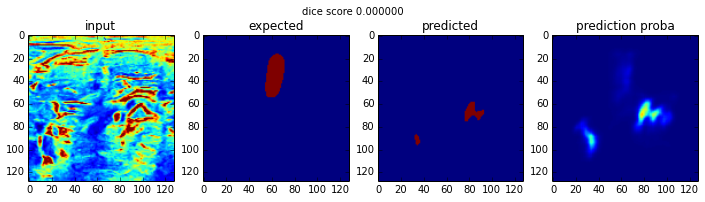

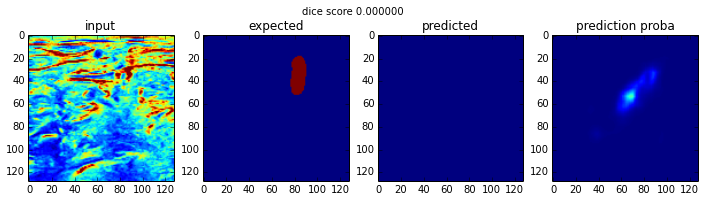

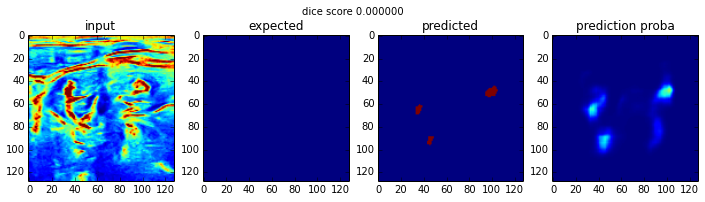

In [102]:
#i = 50
#i = 47

#for i in lowest[2000:2005]:
for i in lowest[:5]:
    pl.figure(figsize=(12, 3))
    pl.suptitle('dice score %f' % utils.dice_coefficient(Y_full_pred[i], Y_full[i]))
    pl.subplot(141)
    pl.title('input')
    pl.imshow(X_full[i].squeeze())
    pl.subplot(142)
    pl.title('expected')
    pl.imshow(Y_full[i].squeeze())
    pl.subplot(143)
    pl.title('predicted')
    pl.imshow(Y_full_pred[i].squeeze(), vmin=0, vmax=1)
    pl.subplot(144)
    
    pl.title('prediction proba')
    pl.imshow(Y_full_pred_proba[i].squeeze(), vmin=0, vmax=1)

# Visualize filters

See http://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [103]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [104]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [105]:
import keras.backend as K

ValueError: GpuDnnConv images and kernel must have the same stack size

Apply node that caused the error: GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})
Toposort index: 70
Inputs types: [CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), <theano.gof.type.CDataType object at 0x7f1a248e6710>, Scalar(float32), Scalar(float32)]
Inputs shapes: [(1, 16, 4, 4), (16, 1, 3, 3), (1, 16, 4, 4), 'No shapes', (), ()]
Inputs strides: [(0, 16, 4, 1), (9, 0, 3, 1), (0, 16, 4, 1), 'No strides', (), ()]
Inputs values: ['not shown', 'not shown', 'not shown', <PyCObject object at 0x7f1a3557f6c0>, 1.0, 0.0]
Inputs name: ('image', 'kernel', 'output', 'descriptor', 'alpha', 'beta')

Outputs clients: [[GpuElemwise{Add}[(0, 0)](GpuDnnConv{algo='small', inplace=True}.0, GpuReshape{4}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

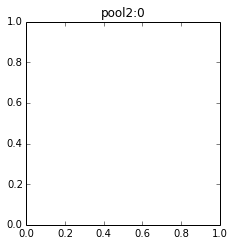

In [106]:
def dream_layer_filter(layer_name, filter_index):

    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, filter_index, :, :])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, input_shape[0], input_shape[1], input_shape[2])) * 0.2 + 0.5
    input_img_data = input_img_data.astype(np.float32)

    orig_img = input_img_data.copy()

    # run gradient ascent for 20 steps
    step = 0.1
    for i in range(40):
        # 0 is to disable training_phase
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data += grads_value * step

        # normalize to 0-1
        #input_img_data = (input_img_data - input_img_data.min()) / (input_img_data.max() - input_img_data.min())

    img = input_img_data[0].squeeze()
    return img
    #img = deprocess_image(img)
    
    
for layer_name in ['pool2', 'pool3', 'pool4', 'pool5']:
    pl.figure(figsize=(16, 8))
    for i in range(8):
        pl.subplot(2, 4, i + 1)
        pl.title('%s:%d' % (layer_name, i))
        img = dream_layer_filter(layer_name, i)
        pl.imshow(img, cmap=cm.gray)